In [1]:
import os
import json
import pandas as pd
import pyspark

In [3]:
#For some reason I could not access dataframe without pip installing findspark and then running this. Don't completely understand
import findspark
findspark.init()

In [5]:
# Create a list of file paths for text files
path = "C:/Users/rdequ/Documents/spark/notebooks/data"
text_file_paths = [
    os.path.join(root, name)
    for root, dirs, files in os.walk(path)
    for name in files
    if name.endswith('.json')
    and not name.endswith('_SUCCESS.json')
]

In [7]:
data = []
def process_json(filename):
    with open(filename, 'r') as f:
        try:
            # Load the JSON data and handle potential errors
            json_data = json.load(f)
            value_dict = json.loads(json_data['value'])

            # Create a dictionary with the extracted values
            data_dict = {
                "aid": value_dict["aid"],
                "title": value_dict["title"],
                "url": value_dict["url"],
                "domain": value_dict["domain"],
                "votes": value_dict["votes"],
                "user": value_dict["user"],
                "posted_at": value_dict["posted_at"],
                "comments": value_dict["comments"],
                "source_title": value_dict["source_title"],
                "source_text": value_dict["source_text"],
                "frontpage": value_dict["frontpage"]
            }

            # Append the dictionary to the data list
            data.append(data_dict)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON file '{filename}': {e}")

# Process each JSON file
for filename in text_file_paths:
    process_json(filename)

# Create the DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Print the DataFrame
print(df)
df.to_csv('reviews150.csv', sep='\t', index=False)

           aid                                              title  \
0     40152353                            The Importance of Maybe   
1     40174439         Noam Chomsky on Where AI Went Wrong (2012)   
2     40165089  Overclocking My Brain: Adapting to Faster Audi...   
3     40173780  We Dropped This Phone from 300 Feet. Here's Wh...   
4     40151430     WordPress Debugging Simplified with Wpdebug.sh   
...        ...                                                ...   
1690  40154202                Building a Micro HTMX SSR Framework   
1691  40173659            WTH Happened to GPT-4's coding ability?   
1692  40151826       Xaira raises 1B for generative AI in biology   
1693  40186740                   Mitigations – Is OpenBSD Secure?   
1694  40164429  Local code completion in VS Code with Cody and...   

                                                    url  \
0     https://zephyrtronium.github.io/articles/lang-...   
1     https://www.youtube.com/playlist?list=PL5lamnB.

In [8]:
df.head()

,aid,title,url,domain,votes,user,posted_at,comments,source_title,source_text,frontpage
0,40152353,The Importance of Maybe,https://zephyrtronium.github.io/articles/lang-...,zephyrtronium.github.io,1,Madxmike,2024-04-25 01:44:44,0,The Importance of Maybe,The Importance of Maybe | zephyrtronium\n\n###...,False
1,40174439,Noam Chomsky on Where AI Went Wrong (2012),https://www.youtube.com/playlist?list=PL5lamnB...,youtube.com,2,max_,2024-04-26 21:20:38,0,Before you continue to YouTube,Before you continue to YouTube\n\nA Google com...,False
2,40165089,Overclocking My Brain: Adapting to Faster Audi...,https://buttondown.email/bimodalblitz/archive/...,buttondown.email/bimodalblitz,1,readtolive,2024-04-26 01:46:30,0,Overclocking My Brain: Adapting to Faster Audi...,Overclocking My Brain: Adapting to Faster Audi...,False
3,40173780,We Dropped This Phone from 300 Feet. Here's Wh...,https://www.wsj.com/video/series/joanna-stern-...,wsj.com,3,gnicholas,2024-04-26 20:21:14,0,wsj.com,wsj.com\n\n,True
4,40151430,WordPress Debugging Simplified with Wpdebug.sh,https://fervid.digital/articles/wordpress-debu...,fervid.digital,1,roymckenzie,2024-04-24 23:53:55,0,WordPress Debugging Simplified with wpdebug.sh...,WordPress Debugging Simplified with wpdebug.sh...,False


In [11]:
df.describe()

,votes,comments
count,1695.000000,1695.000000
mean,3.390560,0.584661
std,7.966186,2.970298
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,128.000000,46.000000


<Axes: xlabel='frontpage', ylabel='comments'>

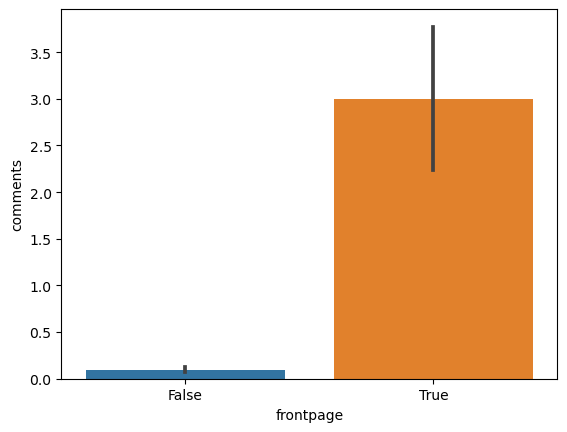

In [13]:
#Look at distributions for votes and comments based on frontpage value:
import matplotlib as plt
import seaborn as sns

sns.barplot(x="frontpage", y="comments", data=df)

<Axes: xlabel='frontpage', ylabel='votes'>

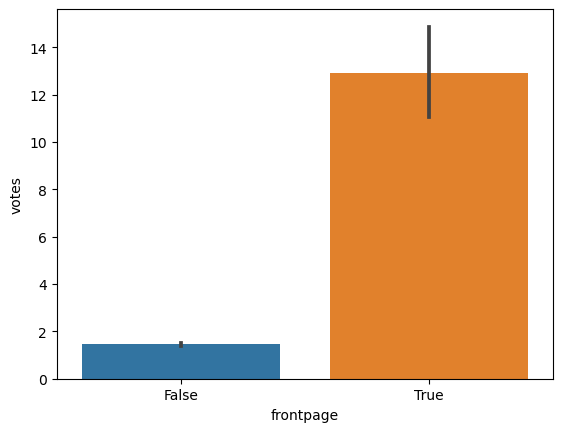

In [17]:
sns.barplot(x="frontpage", y="votes", data=df)

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics


In [21]:
# create a SparkSession 
spark = SparkSession.builder \
    .appName("Deep_learning_txt") \
    .getOrCreate()
spark.conf.set("spark.sql.legacy.setCommandRejectsSparkCoreConfs","false")
spark.conf.set("spark.executor.memory", "15g")
spark.conf.set("spark.executor.cores", "8")
# Remove duplicate row
sdf = spark.createDataFrame(df)
sdf=sdf.dropna()
sdf = sdf.withColumn("frontpage", col("frontpage").cast("integer"))

In [22]:
spark

In [25]:
sdf.printSchema()

root
 |-- aid: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- votes: long (nullable = true)
 |-- user: string (nullable = true)
 |-- posted_at: string (nullable = true)
 |-- comments: long (nullable = true)
 |-- source_title: string (nullable = true)
 |-- source_text: string (nullable = true)
 |-- frontpage: integer (nullable = true)



In [27]:
train_data, test_data = sdf.randomSplit([0.8, 0.2], seed=123)
print("Frontpage: True", train_data.filter(col("frontpage") == True).count()+test_data.filter(col("frontpage") == True).count())
print("Frontpage: False ", train_data.filter(col("frontpage") == False).count()+test_data.filter(col("frontpage") == False).count())

Frontpage: True 282
Frontpage: False  1382


 -  Tokenizer: converts input string to lowercase and then splits it by white spaces
 -  StopWordsRemover: removes stop words from the input
 -  CountVectorizer: Generates a vocabulary and frequency list
 -  IDF: Inverse document frequency. How important is a word

In [29]:
#create a sample weight column using the training data
from pyspark.sql.functions import col
from pyspark.sql.functions import when

counts = train_data.groupBy("frontpage").count().toPandas()
print(counts)

#Counts
count_frontpage = counts[counts["frontpage"]==1]["count"].values[0]
count_total = counts["count"].sum()

#Weights
weight_frontpage= count_total/(2*count_frontpage)
weight_notfront=count_total / (2*(count_total-count_frontpage))

#Add weights as new column in dataframe
train_data = train_data.withColumn("weight", when(col("frontpage")==1, weight_frontpage).otherwise(weight_notfront))

#Check to see if this looks good

train_data.select("frontpage", "weight").where(col("frontpage")==1).show(3)

   frontpage  count
0          1    214
1          0   1104
+---------+------------------+
|frontpage|            weight|
+---------+------------------+
|        1|3.0794392523364484|
|        1|3.0794392523364484|
|        1|3.0794392523364484|
+---------+------------------+
only showing top 3 rows



In [30]:
#sdf = sdf.withColumn("frontpage", col("frontpage").cast("integer"))

# preprocess the data
tokenizer = Tokenizer(inputCol="title", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", locale="en_US")
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="text_features")
featureassembler=VectorAssembler(inputCols=["text_features", "votes", "comments"], outputCol="features")
string_indexer = StringIndexer(inputCol="frontpage", outputCol="label")


In [31]:
#Preprocessing Pipeline:

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, idf, featureassembler, string_indexer])
pre = pipeline.fit(train_data)
train_transformed = pre.transform(train_data)
test_transformed = pre.transform(test_data)

In [34]:
# create models
models = []
models.append(("LR", LogisticRegression(featuresCol="features", labelCol="label")))
models.append(("GB", GBTClassifier(featuresCol="features", labelCol="label")))
models.append(("RF", RandomForestClassifier(featuresCol="features", labelCol="label")))
models.append(("WLR", LogisticRegression(featuresCol="features", labelCol="label",weightCol="weight")))
models.append(("WGB", GBTClassifier(featuresCol="features", labelCol="label",weightCol="weight")))
models.append(("WRF", RandomForestClassifier(featuresCol="features", labelCol="label",weightCol="weight")))

#confusion: how to get accuracy, recall auc????
print("\tAUROC\t\t\tAUPR")
for name, model in models:
    model_trained = model.fit(train_transformed)
    predictions = model_trained.transform(test_transformed)
    #Use binary classification to get auc:
    evaluator = BinaryClassificationEvaluator(labelCol='label')
    auc = evaluator.evaluate(predictions,{evaluator.metricName:'areaUnderROC'})
    aupr = evaluator.evaluate(predictions,{evaluator.metricName:'areaUnderPR'})
    #Get other metrics using an rdd: caused crashing issues for some reason
    #pred_rdd = predictions.select('prediction','label').rdd.map(tuple)
    #metrics = MulticlassMetrics(pred_rdd)
    #accuracy = metrics.accuracy   # Positive class
    #precision = metrics.precision(1.0)  # Positive class
    #recall = metrics.recall(1.0)  # Positive class
    #f1 = metrics.fMeasure(1.0)  # Positive class
    print(f"{name}\t{auc}\t{aupr}")


	AUROC			AUPR
LR	0.907955988150656	0.8063857594456683
GB	0.988335801946678	0.6964562742283469
RF	0.8866906474820144	0.8577579584488122
WLR	0.8536288616165891	0.7103276349084015
WGB	0.9866959373677529	0.5816803951735132
WRF	0.9724396953025815	0.8799700581055311


In [36]:
#Best model is random forest with sample weights. Fit full pipeline to save the model:
gb = GBTClassifier(featuresCol="features", labelCol="frontpage",weightCol="weight")
final_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, idf, featureassembler, gb])
evaluator = BinaryClassificationEvaluator(labelCol='frontpage')

final_model = final_pipeline.fit(train_data)
predictions = final_model.transform(test_data)

auc = evaluator.evaluate(predictions,{evaluator.metricName:'areaUnderROC'})
aupr = evaluator.evaluate(predictions,{evaluator.metricName:'areaUnderPR'})

print("auroc: "+ str(auc))
print("aupr:  "+ str(aupr))

auroc: 0.9488997037663987
aupr:  0.8674312726570351


In [38]:
final_model.save("gb_Model")

Py4JJavaError: An error occurred while calling o1017.save.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.hadoop.mapred.FileOutputCommitter.setupJob(FileOutputCommitter.java:131)
	at org.apache.hadoop.mapred.OutputCommitter.setupJob(OutputCommitter.java:265)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:79)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1593)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1593)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1579)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1579)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1(Pipeline.scala:250)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1$adapted(Pipeline.scala:247)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.saveImpl(Pipeline.scala:247)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.saveImpl(Pipeline.scala:346)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:341)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:331)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:370)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:955)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:192)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:215)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:91)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1111)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1120)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 23 more
